In [ ]:
#default_exp core

In [ ]:
#export
from local.test import *
from local.imports import *
from local.notebook.showdoc import show_doc

In [ ]:
#export
torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

# Core

> Basic functions used in the fastai library

In [ ]:
# export
defaults = SimpleNamespace()

## Metaclasses

In [ ]:
#export
class PrePostInitMeta(type):
    "A metaclass that calls optional `__pre_init__` and `__post_init__` methods"
    def __new__(cls, name, bases, dct):
        x = super().__new__(cls, name, bases, dct)
        def _pass(self, *args,**kwargs): pass
        for o in ('__init__', '__pre_init__', '__post_init__'):
            if not hasattr(x,o): setattr(x,o,_pass)
        old_init = x.__init__
        
        @functools.wraps(old_init)
        def _init(self,*args,**kwargs):
            self.__pre_init__()
            old_init(self, *args,**kwargs)
            self.__post_init__()
        setattr(x, '__init__', _init)
        return x

In [ ]:
show_doc(PrePostInitMeta, title_level=3)

<h3 id="<code>class</code> <code>PrePostInitMeta</code>" class="doc_header"><code>class</code> <code>PrePostInitMeta</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#Metaclasses" class="source_link" style="float:right">[source]</a></h3>

> <code>PrePostInitMeta</code>(**`name`**, **`bases`**, **`dct`**) :: `type`

A metaclass that calls optional `__pre_init__` and `__post_init__` methods

In [ ]:
class _T(metaclass=PrePostInitMeta):
    def __pre_init__(self):  self.a  = 0; assert self.a==0
    def __init__(self):      self.a += 1; assert self.a==1
    def __post_init__(self): self.a += 1; assert self.a==2

t = _T()
t.a

2

In [ ]:
#export
class PrePostInit(metaclass=PrePostInitMeta):
    "Base class that provides `PrePostInitMeta` metaclass to subclasses"
    pass

In [ ]:
class _T(PrePostInit):
    def __pre_init__(self):  self.a  = 0; assert self.a==0
    def __init__(self):      self.a += 1; assert self.a==1
    def __post_init__(self): self.a += 1; assert self.a==2

t = _T()
t.a

2

In [ ]:
#export
class NewChkMeta(PrePostInitMeta):
    "Metaclass to avoid recreating object passed to constructor (plus all `PrePostInitMeta` functionality)"
    def __new__(cls, name, bases, dct):
        x = super().__new__(cls, name, bases, dct)
        old_init,old_new = x.__init__,x.__new__

        @functools.wraps(old_init)
        def _new(cls, x=None, *args, **kwargs):
            if x is not None and isinstance(x,cls):
                x._newchk = 1
                return x
            res = old_new(cls)
            res._newchk = 0
            return res

        @functools.wraps(old_init)
        def _init(self,*args,**kwargs):
            if self._newchk: return
            old_init(self, *args, **kwargs)

        x.__init__,x.__new__ = _init,_new
        return x

In [ ]:
class _T(metaclass=NewChkMeta):
    "Testing"
    def __init__(self, o=None): self.foo = getattr(o,'foo',0) + 1

class _T2():
    def __init__(self, o): self.foo = getattr(o,'foo',0) + 1

t = _T(1)
test_eq(t.foo,1)
t2 = _T(t)
test_eq(t2.foo,1)
test_is(t,t2)

t = _T2(1)
test_eq(t.foo,1)
t2 = _T2(t)
test_eq(t2.foo,2)

test_eq(_T.__doc__, "Testing")
test_eq(str(inspect.signature(_T)), '(o=None)')

## Foundational functions

### Decorators

In [ ]:
import copy

In [ ]:
#export
def patch_to(cls, as_prop=False):
    "Decorator: add `f` to `cls`"
    def _inner(f):
        nf = copy.copy(f)
        # `functools.update_wrapper` when passing patched function to `Pipeline`, so we do it manually
        for o in functools.WRAPPER_ASSIGNMENTS: setattr(nf, o, getattr(f,o))
        nf.__qualname__ = f"{cls.__name__}.{f.__name__}"
        setattr(cls, f.__name__, property(nf) if as_prop else nf)
        return f
    return _inner

In [ ]:
class _T3(int): pass

@patch_to(_T3)
def func1(x, a:bool): return x+2

t = _T3(1)
test_eq(t.func1(1), 3)

In [ ]:
#export
def patch(f):
    "Decorator: add `f` to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls)(f)

In [ ]:
@patch
def func(x:_T3, a:bool):
    "test"
    return x+2

t = _T3(1)
test_eq(t.func(1), 3)
test_eq(t.func.__qualname__, '_T3.func')

In [ ]:
#export
def patch_property(f):
    "Decorator: add `f` as a property to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls, as_prop=True)(f)

In [ ]:
@patch_property
def prop(x:_T3): return x+1

t = _T3(1)
test_eq(t.prop, 2)

### Type checking

Runtime type checking is handy, so let's make it easy!

In [ ]:
#export core
#NB: Please don't move this to a different line or module, since it's used in testing `get_source_link`
def chk(f): return typechecked(always=True)(f)

Decorator for a function to check that type-annotated arguments receive arguments of the right type.

In [ ]:
@chk
def test_chk(a:int=1): return a

test_eq(test_chk(2), 2)
test_eq(test_chk(), 1)
test_fail(lambda: test_chk('a'), contains='"a" must be int')

Decorated functions will pickle correctly.

In [ ]:
t = pickle.loads(pickle.dumps(test_chk))
test_eq(t(2), 2)
test_eq(t(), 1)

### Context managers

In [ ]:
@contextmanager
def working_directory(path):
    "Change working directory to `path` and return to previous on exit."
    prev_cwd = Path.cwd()
    os.chdir(path)
    try: yield
    finally: os.chdir(prev_cwd)

### Monkey-patching

In [ ]:
#export
#NB: Please don't move this to a different line or module, since it's used in testing `get_source_link`
@patch
def ls(self:Path):
    "Contents of path as a list"
    return list(self.iterdir())

We add an `ls()` method to `pathlib.Path` which is simply defined as `list(Path.iterdir())`, mainly for convenience in REPL environments such as notebooks.

In [ ]:
path = Path()
t = path.ls()
assert len(t)>0
t[0]

PosixPath('18_callback_fp16.ipynb')

In [ ]:
#hide
pkl = pickle.dumps(path)
p2 =pickle.loads(pkl)
test_eq(path.ls()[0], p2.ls()[0])

In [ ]:
def is_listy(x): return isinstance(x,(list,tuple,Generator))

In [ ]:
#export
def tensor(x, *rest, **kwargs):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # Pytorch bug in dataloader using num_workers>0
    if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    res = (torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
           else as_tensor(x, **kwargs) if hasattr(x, '__array__')
           else as_tensor(x, **kwargs) if is_listy(x)
           else as_tensor(x, **kwargs) if is_iter(x)
           else None)
    if res is None:
        res = as_tensor(array(x), **kwargs)
        if res.dtype is torch.float64: return res.float()
    if res.dtype is torch.int32:
        warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
        return res.long()
    return res

In [ ]:
test_eq(tensor(array([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(1,2,3), torch.tensor([1,2,3]))
test_eq_type(tensor(1.0), torch.tensor(1.0))

#### `Tensor.ndim`

We add an `ndim` property to `Tensor` with same semantics as [numpy ndim](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.ndim.html), which allows tensors to be used in matplotlib and other places that assume this property exists.

In [ ]:
test_eq(torch.tensor([1,2]).ndim,1)
test_eq(torch.tensor(1).ndim,0)
test_eq(torch.tensor([[1]]).ndim,2)

### Documentation functions

In [ ]:
#export core
def add_docs(cls, cls_doc=None, **docs):
    "Copy values from `docs` to `cls` docstrings, and confirm all public methods are documented"
    if cls_doc is not None: cls.__doc__ = cls_doc
    for k,v in docs.items():
        f = getattr(cls,k)
        if hasattr(f,'__func__'): f = f.__func__ # required for class methods
        f.__doc__ = v
    # List of public callables without docstring
    nodoc = [c for n,c in vars(cls).items() if isinstance(c,Callable)
             and not n.startswith('_') and c.__doc__ is None]
    assert not nodoc, f"Missing docs: {nodoc}"
    assert cls.__doc__ is not None, f"Missing class docs: {cls}"

In [ ]:
#export core
def docs(cls):
    "Decorator version of `add_docs"
    add_docs(cls, **cls._docs)
    return cls

In [ ]:
class _T:
    def f(self): pass
    @classmethod
    def g(cls): pass
add_docs(_T, "a", f="f", g="g")

test_eq(_T.__doc__, "a")
test_eq(_T.f.__doc__, "f")
test_eq(_T.g.__doc__, "g")

In [ ]:
#export
def custom_dir(c, add:List):
    "Implement custom `__dir__`, adding `add` to `cls`"
    return dir(type(c)) + list(c.__dict__.keys()) + add

In [ ]:
show_doc(is_iter)

<h4 id="<code>is_iter</code>" class="doc_header"><code>is_iter</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/local/imports.py#L32" class="source_link" style="float:right">[source]</a></h4>

> <code>is_iter</code>(**`o`**)

Test whether `o` can be used in a `for` loop

In [ ]:
assert is_iter([1])
assert not is_iter(torch.tensor(1))
assert is_iter(torch.tensor([1,2]))
assert (o for o in range(3))

In [ ]:
# export
def coll_repr(c, max=1000):
    "String repr of up to `max` items of (possibly lazy) collection `c`"
    return f'(#{len(c)}) [' + ','.join(itertools.islice(map(str,c), 10)) + ('...'
            if len(c)>10 else '') + ']'

In [ ]:
test_eq(coll_repr(range(1000)), '(#1000) [0,1,2,3,4,5,6,7,8,9...]')

## GetAttr -

In [ ]:
#export
class GetAttr:
    "Inherit from this to have all attr accesses in `self._xtra` passed down to `self.default`"
    _xtra=[]
    def __getattr__(self,k):
        assert self._xtra, "Inherited from `GetAttr` but no `_xtra` attrs listed"
        if k in self._xtra: return getattr(self.default, k)
        raise AttributeError(k)
    def __dir__(self): return custom_dir(self, self._xtra)

In [ ]:
class _C(GetAttr): default,_xtra = 'Hi',['lower']

t = _C()
test_eq(t.lower(), 'hi')
test_fail(lambda: t.upper())
assert 'lower' in dir(t)

## L -

In [ ]:
# export
def _mask2idxs(mask):
    mask = list(mask)
    if len(mask)==0: return []
    if isinstance(mask[0],bool): return [i for i,m in enumerate(mask) if m]
    return [int(i) for i in mask]

def _listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, (str,np.ndarray,Tensor)): return [o]
    if is_iter(o): return list(o)
    return [o]

In [ ]:
#export
class L(GetAttr, metaclass=NewChkMeta):
    "Behaves like a list of `items` but can also index with list of indices or masks"
    _xtra =  [o for o in dir([]) if not o.startswith('_')]

    def __init__(self, items=None, *rest, use_list=False, match=None):
        if rest: items = (items,)+rest
        if items is None: items = []
        self.items = self.default = list(items) if use_list else _listify(items)
        if match is not None:
            if len(self.items)==1: self.items = self.items*len(match)
            else: assert len(self.items)==len(match), 'Match length mismatch'
        
    def __len__(self): return len(self.items)
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): return f'{coll_repr(self)}'
    def __eq__(self,b): return all_equal(b,self)
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __invert__(self): return L(not i for i in self)
    def __mul__ (a,b): return L(a.items*b)
    def __add__ (a,b): return L(a.items+_listify(b))
    def __radd__(a,b): return L(b)+a
    def __addi__(a,b):
        a.items += list(b)
        return a
    
    def __getitem__(self, idx):
        "Retrieve `idx` (can be list of indices, or mask, or int) items"
        res = [self.items[i] for i in _mask2idxs(idx)] if is_iter(idx) else self.items[idx]
#         if isinstance(res,(tuple,list)) and not isinstance(res,L): res = L(res)
        return res
    
    def __setitem__(self, idx, o):
        "Set `idx` (can be list of indices, or mask, or int) items to `o` (which is broadcast if not iterable)"
        idx = idx if isinstance(idx,L) else _listify(idx) 
        if not is_iter(o): o = [o]*len(idx)
        for i,o_ in zip(idx,o): self.items[i] = o_

    def sorted(self, key=None, reverse=False):
        "New `L` sorted by `key`. If key is str then use `attrgetter`. If key is int then use `itemgetter`."
        if isinstance(key,str):   k=lambda o:getattr(o,key,0)
        elif isinstance(key,int): k=itemgetter(key)
        else: k=key
        return L(sorted(self.items, key=k, reverse=reverse))
    
    @classmethod
    def range(self, a, b=None, step=None):
        "Same as builtin `range`, but returns an `L`. Can pass a collection for `a`, to use `len(a)`"
        if is_coll(a): a = len(a)
        return L(range(a,b,step)) if step is not None else L(range(a,b)) if b is not None else L(range(a))
    
    def mapped(self, f, *args, **kwargs): return L(map(partial(f,*args,**kwargs), self))
    def zipped(self):       return L(zip(*self))
    def zipwith(self, *rest):       return L(zip(self, *rest))
    def itemgot(self, idx): return self.mapped(itemgetter(idx))
    def attrgot(self, k):   return self.mapped(lambda o:getattr(o,k,0))
    def tensored(self):     return self.mapped(tensor)
    def stack(self, dim=0): return torch.stack(list(self.tensored()), dim=dim)
    def cat  (self, dim=0): return torch.cat  (list(self.tensored()), dim=dim)
    def cycle(self):        return itertools.cycle(self) if len(self) > 0 else itertools.cycle([None])

In [ ]:
add_docs(L,
         mapped="Create new `L` with `f` applied to all `items`, passing `args` and `kwargs` to `f`",
         zipped="Create new `L` with `zip(*items)`",
         zipwith="Create new `L` with `self` zipped with each of `*rest`",
         itemgot="Create new `L` with item `idx` of all `items`",
         attrgot="Create new `L` with attr `k` of all `items`",
         tensored="`mapped(tensor)`",
         cycle="Same as `itertools.cycle`",
         stack="Same as `torch.stack`",
         cat="Same as `torch.cat`")

You can create an `L` from an existing iterable (e.g. a list, range, etc) and access or modify it with an int list/tuple index, mask, int, or slice. All `list` methods can also be used with `L`.

In [ ]:
t = L(range(12))
test_eq(t, list(range(12)))
test_ne(t, list(range(11)))
t.reverse()
test_eq(t[0], 11)
t[3] = "h"
test_eq(t[3], "h")
t[3,5] = ("j","k")
test_eq(t[3,5], ["j","k"])
test_eq(t, L(t))
t

(#12) [11,10,9,j,7,k,5,4,3,2...]

You can also modify an `L` with `append`, `+`, and `*`.

In [ ]:
t = L()
test_eq(t, [])
t.append(1)
test_eq(t, [1])
t += [3,2]
test_eq(t, [1,3,2])
t = t + [4]
test_eq(t, [1,3,2,4])
t = 5 + t
test_eq(t, [5,1,3,2,4])
test_eq(L(1,2,3), [1,2,3])
test_eq(L(1,2,3), L(1,2,3))
t = L(1)*5
t = t.mapped(operator.neg)
test_eq(t,[-1]*5)
test_eq(~L([True,False,False]), L([False,True,True]))
t = L(range(4))
test_eq(zip(t, L(1).cycle()), zip(range(4),(1,1,1,1)))

In [ ]:
def _f(x,a=0): return x+a
t = L(1)*5
test_eq(t.mapped(_f), t)
test_eq(t.mapped(_f,1), [2]*5)
test_eq(t.mapped(_f,a=2), [3]*5)

An `L` can be constructed from anything iterable, although tensors and arrays will not be iterated over on construction, unless you pass `use_list` to the constructor.

In [ ]:
test_eq(L([1,2,3]),[1,2,3])
test_eq(L(L([1,2,3])),[1,2,3])
test_ne(L([1,2,3]),[1,2,])
test_eq(L('abc'),['abc'])
test_eq(L(range(0,3)),[0,1,2])
test_eq(L(o for o in range(0,3)),[0,1,2])
test_eq(L(tensor(0)),[tensor(0)])
test_eq(L([tensor(0),tensor(1)]),[tensor(0),tensor(1)])
test_eq(L(tensor([0.,1.1]))[0],tensor([0.,1.1]))
test_eq(L(tensor([0.,1.1]), use_list=True), [0.,1.1])  # `use_list=True` to unwrap arrays/tensors

If `match` is not `None` then the created list is same len as `match`, either by:

- If `len(items)==1` then `items` is replicated,
- Otherwise an error is raised if `match` and `items` are not already the same size.

In [ ]:
test_eq(L(1,match=[1,2,3]),[1,1,1])
test_eq(L([1,2],match=[2,3]),[1,2])
test_fail(lambda: L([1,2],match=[1,2,3]))

If you create an `L` from an existing `L` then you'll get back the original object (since `L` uses the `NewChkMeta` metaclass).

In [ ]:
test_is(L(t), t)

### Methods

In [ ]:
show_doc(L.__getitem__)

<h4 id="<code>L.__getitem__</code>" class="doc_header"><code>L.__getitem__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.__getitem__</code>(**`idx`**)

Retrieve `idx` (can be list of indices, or mask, or int) items

In [ ]:
t = L(range(12))
test_eq(t[1,2], [1,2])                # implicit tuple
test_eq(t[[1,2]], [1,2])              # list
test_eq(t[:3], [0,1,2])               # slice
test_eq(t[[False]*11 + [True]], [11]) # mask
test_eq(t[tensor(3)], 3)

In [ ]:
show_doc(L.__setitem__)

<h4 id="<code>L.__setitem__</code>" class="doc_header"><code>L.__setitem__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.__setitem__</code>(**`idx`**, **`o`**)

Set `idx` (can be list of indices, or mask, or int) items to `o` (which is broadcast if not iterable)

In [ ]:
t[4,6] = 0
test_eq(t[4,6], [0,0])
t[4,6] = [1,2]
test_eq(t[4,6], [1,2])

In [ ]:
show_doc(L.mapped)

<h4 id="<code>L.mapped</code>" class="doc_header"><code>L.mapped</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.mapped</code>(**`f`**, **\*`args`**, **\*\*`kwargs`**)

Create new [`L`](/core.html#L) with `f` applied to all `items`, passing `args` and `kwargs` to `f`

In [ ]:
test_eq(L(range(4)).mapped(operator.neg), [0,-1,-2,-3])

In [ ]:
show_doc(L.zipped)

<h4 id="<code>L.zipped</code>" class="doc_header"><code>L.zipped</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.zipped</code>()

Create new [`L`](/core.html#L) with `zip(*items)`

In [ ]:
t = L([[1,2,3],'abc'])
test_eq(t.zipped(), [(1, 'a'),(2, 'b'),(3, 'c')])

In [ ]:
show_doc(L.zipwith)

<h4 id="<code>L.zipwith</code>" class="doc_header"><code>L.zipwith</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.zipwith</code>(**\*`rest`**)

Create new [`L`](/core.html#L) with `self` zipped with each of `*rest`

In [ ]:
t = L(1,2,3).zipwith([0,1,2])
test_eq(t, [(1, 0),(2, 1),(3, 2)])

In [ ]:
show_doc(L.itemgot)

<h4 id="<code>L.itemgot</code>" class="doc_header"><code>L.itemgot</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.itemgot</code>(**`idx`**)

Create new [`L`](/core.html#L) with item `idx` of all `items`

In [ ]:
test_eq(t.itemgot(1), [0,1,2])

In [ ]:
show_doc(L.attrgot)

<h4 id="<code>L.attrgot</code>" class="doc_header"><code>L.attrgot</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.attrgot</code>(**`k`**)

Create new [`L`](/core.html#L) with attr `k` of all `items`

In [ ]:
a = [SimpleNamespace(a=3,b=4),SimpleNamespace(a=1,b=2)]
test_eq(L(a).attrgot('b'), [4,2])

In [ ]:
show_doc(L.sorted)

<h4 id="<code>L.sorted</code>" class="doc_header"><code>L.sorted</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.sorted</code>(**`key`**=*`None`*, **`reverse`**=*`False`*)

New [`L`](/core.html#L) sorted by `key`. If key is str then use `attrgetter`. If key is int then use `itemgetter`.

In [ ]:
test_eq(L(a).sorted('a').attrgot('b'), [2,4])

In [ ]:
show_doc(L.range)

<h4 id="<code>L.range</code>" class="doc_header"><code>L.range</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/01_core.ipynb#L--" class="source_link" style="float:right">[source]</a></h4>

> <code>L.range</code>(**`a`**, **`b`**=*`None`*, **`step`**=*`None`*)

Same as builtin `range`, but returns an [`L`](/core.html#L). Can pass a collection for `a`, to use `len(a)`

In [ ]:
test_eq_type(L.range([1,1,1]), L(range(3)))
test_eq_type(L.range(5,2,2), L(range(5,2,2)))

### Tensor methods

There are shortcuts for `torch.stack` and `torch.cat` if your `L` contains tensors or something convertible. You can manually convert with `tensored`.

In [ ]:
t = L(([1,2],[3,4]))

In [ ]:
test_eq(t.tensored(), [tensor(1,2),tensor(3,4)])
test_eq(t.stack(), tensor([[1,2],[3,4]]))
test_eq(t.cat(), tensor([1,2,3,4]))

## Utility functions

### Basics

In [ ]:
# export
def ifnone(a, b):
    "`b` if `a` is None else `a`"
    return b if a is None else a

Since `b if a is None else a` is such a common pattern, we wrap it in a function. However, be careful, because python will evaluate *both* `a` and `b` when calling `ifnone` (which it doesn't do if using the `if` version directly).

In [ ]:
test_eq(ifnone(None,1), 1)
test_eq(ifnone(2   ,1), 2)

In [ ]:
#export
def get_class(nm, *fld_names, sup=None, doc=None, funcs=None, **flds):
    "Dynamically create a class, optionally inheriting from `sup`, containing `fld_names`"
    attrs = {}
    for f in fld_names: attrs[f] = None
    for f in L(funcs): attrs[f.__name__] = f
    for k,v in flds.items(): attrs[k] = v
    sup = ifnone(sup, ())
    if not isinstance(sup, tuple): sup=(sup,)
    
    def _init(self, *args, **kwargs):
        for i,v in enumerate(args): setattr(self, list(attrs.keys())[i], v)
        for k,v in kwargs.items(): setattr(self,k,v)
            
    def _repr(self):
        return '\n'.join(f'{o}: {getattr(self,o)}' for o in set(dir(self))
                         if not o.startswith('_') and not isinstance(getattr(self,o), types.MethodType))
    
    if not sup: flds['__repr__'] = _repr
    attrs['__init__'] = _init
    res = type(nm, sup, attrs)
    if doc is not None: res.__doc__ = doc
    return res

In [ ]:
_t = get_class('_t', 'a', b=2)
t = _t()
test_eq(t.a, None)
test_eq(t.b, 2)
t = _t(1, b=3)
test_eq(t.a, 1)
test_eq(t.b, 3)
t = _t(1, 3)
test_eq(t.a, 1)
test_eq(t.b, 3)

Most often you'll want to call `mk_class`, since it adds the class to your module. See `mk_class` for more details and examples of use (which also apply to `get_class`).

In [ ]:
#export
def mk_class(nm, *fld_names, sup=None, doc=None, funcs=None, mod=None, **flds):
    "Create a class using `get_class` and add to the caller's module"
    if mod is None: mod = inspect.currentframe().f_back.f_locals
    res = get_class(nm, *fld_names, sup=sup, doc=doc, funcs=funcs, **flds)
    mod[nm] = res

Any `kwargs` will be added as class attributes, and `sup` is an optional (tuple of) base classes.

In [ ]:
mk_class('_t', a=1, sup=GetAttr)
t = _t()
test_eq(t.a, 1)
assert(isinstance(t,GetAttr))

A `__init__` is provided that sets attrs for any `kwargs`, and for any `args` (matching by position to fields), along with a `__repr__` which prints all attrs. The docstring is set to `doc`. You can pass `funcs` which will be added as attrs with the function names.

In [ ]:
def foo(self): return 1
mk_class('_t', 'a', sup=GetAttr, doc='test doc', funcs=foo)

t = _t(3, b=2)
test_eq(t.a, 3)
test_eq(t.b, 2)
test_eq(t.foo(), 1)
test_eq(t.__doc__, 'test doc')
t

In [ ]:
#export
def wrap_class(nm, *fld_names, sup=None, doc=None, funcs=None, **flds):
    "Decorator: makes function a method of a new class `nm` passing parameters to `mk_class`"
    def _inner(f):
        mk_class(nm, *fld_names, sup=sup, doc=doc, funcs=L(funcs)+f, mod=f.__globals__, **flds)
        return f
    return _inner

In [ ]:
@wrap_class('_t', a=2)
def bar(self,x): return x+1

t = _t()
test_eq(t.a, 2)
test_eq(t.bar(3), 4)

In [ ]:
# export
def noop (x=None, *args, **kwargs):
    "Do nothing"
    return x

In [ ]:
noop()
test_eq(noop(1),1)

In [ ]:
# export
def noops(self, x, *args, **kwargs):
    "Do nothing (method)"
    return x

In [ ]:
mk_class('_t', foo=noops)
test_eq(_t().foo(1),1)

### Collection functions

In [ ]:
#export
def tuplify(o, use_list=False, match=None):
    "Make `o` a tuple"
    return tuple(L(o, use_list=use_list, match=match))

In [ ]:
test_eq(tuplify(None),())
test_eq(tuplify([1,2,3]),(1,2,3))
test_eq(tuplify(1,match=[1,2,3]),(1,1,1))

In [ ]:
#export
def replicate(item,match):
    "Create tuple of `item` copied `len(match)` times"
    return (item,)*len(match)

In [ ]:
t = [1,1]
test_eq(replicate([1,2], t),([1,2],[1,2]))
test_eq(replicate(1, t),(1,1))

In [ ]:
#export
def uniqueify(x, sort=False, bidir=False, start=None):
    "Return the unique elements in `x`, optionally `sort`-ed, optionally return the reverse correspondance."
    res = list(OrderedDict.fromkeys(x).keys())
    if start is not None: res = L(start)+res
    if sort: res.sort()
    if bidir: return res, {v:k for k,v in enumerate(res)}
    return res

In [ ]:
# test
test_eq(set(uniqueify([1,1,0,5,0,3])),{0,1,3,5})
test_eq(uniqueify([1,1,0,5,0,3], sort=True),[0,1,3,5])
v,o = uniqueify([1,1,0,5,0,3], bidir=True)
test_eq(v,[1,0,5,3])
test_eq(o,{1:0, 0: 1, 5: 2, 3: 3})
v,o = uniqueify([1,1,0,5,0,3], sort=True, bidir=True)
test_eq(v,[0,1,3,5])
test_eq(o,{0:0, 1: 1, 3: 2, 5: 3})

In [ ]:
# export
def setify(o): return o if isinstance(o,set) else set(L(o))

In [ ]:
# test
test_eq(setify(None),set())
test_eq(setify('abc'),{'abc'})
test_eq(setify([1,2,2]),{1,2})
test_eq(setify(range(0,3)),{0,1,2})
test_eq(setify({1,2}),{1,2})

In [ ]:
#export
def is_listy(x):
    "`isinstance(x, (tuple,list,L))`"
    return isinstance(x, (tuple,list,L,slice,Generator))

In [ ]:
assert is_listy([1])
assert is_listy(L([1]))
assert is_listy(slice(2))
assert not is_listy(torch.tensor([1]))

In [ ]:
#export
def range_of(x):
    "All indices of collection `x` (i.e. `list(range(len(x)))`)"
    return list(range(len(x)))

In [ ]:
test_eq(range_of([1,1,1,1]), [0,1,2,3])

In [ ]:
# export
def mask2idxs(mask):
    "Convert bool mask or index list to index `L`"
    return L(_mask2idxs(mask))

In [ ]:
test_eq(mask2idxs([False,True,False,True]), [1,3])
test_eq(mask2idxs(torch.tensor([1,2,3])), [1,2,3])

In [ ]:
#export
def merge(*ds):
    "Merge all dictionaries in `ds`"
    return {k:v for d in ds for k,v in d.items()}

In [ ]:
test_eq(merge(), {})
test_eq(merge(dict(a=1,b=2)), dict(a=1,b=2))
test_eq(merge(dict(a=1,b=2), dict(b=3,c=4)), dict(a=1, b=3, c=4))

In [ ]:
#export
def shufflish(x, pct=0.04):
    "Randomly relocate items of `x` up to `pct` of `len(x)` from their starting location"
    n = len(x)
    return L(x[i] for i in sorted(range_of(x), key=lambda o: o+n*(1+random.random()*pct)))

In [ ]:
l = list(range(100))
l2 = array(shufflish(l))
test_close(l2[:50 ].mean(), 25, eps=5)
test_close(l2[-50:].mean(), 75, eps=5)
test_ne(l,l2)

### File and network functions

In [ ]:
def bunzip(fn):
    "bunzip `fn`, raising exception if output already exists"
    fn = Path(fn)
    assert fn.exists(), f"{fn} doesn't exist"
    out_fn = fn.with_suffix('')
    assert not out_fn.exists(), f"{out_fn} already exists"
    with bz2.BZ2File(fn, 'rb') as src, out_fn.open('wb') as dst:
        for d in iter(lambda: src.read(1024*1024), b''): dst.write(d)

In [ ]:
f = Path('files/test.txt')
if f.exists(): f.unlink()
bunzip('files/test.txt.bz2')
t = f.open().readlines()
test_eq(len(t),1)
test_eq(t[0], 'test\n')
f.unlink()

### Tensor functions

In [ ]:
#export
def apply(func, x, *args, **kwargs):
    "Apply `func` recursively to `x`, passing on args"
    if is_listy(x): return x.__class__(apply(func, o, *args, **kwargs) for o in x)
    if isinstance(x,dict):  return {k: apply(func, v, *args, **kwargs) for k,v in x.items()}
    return func(x, *args, **kwargs)

In [ ]:
#export
def to_detach(b, cpu=True):
    "Recursively detach lists of tensors in `b `; put them on the CPU if `cpu=True`."
    def _inner(x, cpu=True):
        if not isinstance(x,Tensor): return x
        x = x.detach()
        return x.cpu() if cpu else x
    return apply(_inner, b, cpu=cpu)

In [ ]:
#export
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if x.dtype not in [torch.int64, torch.int32, torch.int16] else x, b)

In [ ]:
#export
def to_float(b):
    "Recursively map lists of int tensors in `b ` to float."
    return apply(lambda x: x.float() if x.dtype not in [torch.int64, torch.int32, torch.int16] else x, b)

In [ ]:
#export
# None: True if available; True: error if not availabe; False: use CPU
defaults.use_cuda = None

In [ ]:
#export
def default_device(use_cuda=-1):
    "Return or set default device; `use_cuda`: None - CUDA if available; True - error if not availabe; False - CPU"
    if use_cuda != -1: defaults.use_cuda=use_cuda
    use = defaults.use_cuda or (torch.cuda.is_available() and defaults.use_cuda is None)
    assert torch.cuda.is_available() or not use
    return torch.device(torch.cuda.current_device()) if use else torch.device('cpu')

In [ ]:
#cuda
_td = torch.device(torch.cuda.current_device())
test_eq(default_device(None), _td)
test_eq(default_device(True), _td)
test_eq(default_device(False), torch.device('cpu'))
default_device(None);

In [ ]:
#export
def to_device(b, device=None):
    "Recursively put `b` on `device`."
    if device is None: device=default_device()
    def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o
    return apply(_inner, b)

In [ ]:
t = to_device((3,(tensor(3),tensor(2))))
t1,(t2,t3) = t
test_eq_type(t,(3,(tensor(3).cuda(),tensor(2).cuda())))
test_eq(t2.type(), "torch.cuda.LongTensor")
test_eq(t3.type(), "torch.cuda.LongTensor")

In [ ]:
#export
def to_cpu(b):
    "Recursively map lists of tensors in `b ` to the cpu."
    return to_device(b,'cpu')

In [ ]:
t3 = to_cpu(t3)
test_eq(t3.type(), "torch.LongTensor")
test_eq(t3, 2)

In [ ]:
def to_np(x):
    "Convert a tensor to a numpy array."
    return x.data.cpu().numpy()

In [ ]:
t3 = to_np(t3)
test_eq(type(t3), np.ndarray)
test_eq(t3, 2)

In [ ]:
#export
def item_find(x, idx=0):
    "Recursively takes the `idx`-th element of `x`"
    if is_listy(x): return item_find(x[idx])
    if isinstance(x,dict):  
        key = list(x.keys())[idx] if isinstance(idx, int) else idx
        return item_find(x[key])
    return x

In [ ]:
#export
def find_device(b):
    "Recursively search the device of `b`."
    return item_find(b).device

In [ ]:
dev = default_device()
test_eq(find_device(t2), dev)
test_eq(find_device([t2,t2]), dev)
test_eq(find_device({'a':t2,'b':t2}), dev)
test_eq(find_device({'a':[[t2],[t2]],'b':t2}), dev)

In [ ]:
#export
def find_bs(b):
    "Recursively search the batch size of `b`."
    return item_find(b).shape[0]

In [ ]:
x = torch.randn(4,5)
test_eq(find_bs(x), 4)
test_eq(find_bs([x, x]), 4)
test_eq(find_bs({'a':x,'b':x}), 4)
test_eq(find_bs({'a':[[x],[x]],'b':x}), 4)

In [ ]:
def np_func(f):
    "Convert a function taking and returning numpy arrays to one taking and returning tensors"
    def _inner(*args, **kwargs):
        nargs = [to_np(arg) if isinstance(arg,Tensor) else arg for arg in args]
        return tensor(f(*nargs, **kwargs))
    functools.update_wrapper(_inner, f)
    return _inner

This decorator is particularly useful for using numpy functions as fastai metrics, for instance:

In [ ]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, inp)

a1,a2 = array([0,1,1]),array([1,0,1])
t = f1(tensor(a1),tensor(a2))
test_eq(f1_score(a1,a2), t)
assert isinstance(t,Tensor)

In [ ]:
class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self): super().__init__()
    def __init__(self): pass

In [ ]:
show_doc(Module, title_level=3)

<h3 id="<code>class</code> <code>Module</code>" class="doc_header"><code>class</code> <code>Module</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/11_layers.ipynb#Basic-manipulations-and-resize" class="source_link" style="float:right">[source]</a></h3>

> <code>Module</code>() :: [`Module`](/layers.html#Module)

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

In [ ]:
class _T(Module):
    def __init__(self): self.f = nn.Linear(1,1)
    def forward(self,x): return self.f(x)

t = _T()
t(tensor([1.]))

tensor([1.5737], grad_fn=<AddBackward0>)

### Functions on functions

In [ ]:
# export
@chk
def compose(*funcs: Callable, order=None):
    "Create a function that composes all functions in `funcs`, passing along remaining `*args` and `**kwargs` to all"
    funcs = L(funcs)
    if order is not None: funcs = funcs.sorted(order)
    def _inner(x, *args, **kwargs):
        for f in L(funcs): x = f(x, *args, **kwargs)
        return x
    return _inner

In [ ]:
f1 = lambda o,p=0: (o*2)+p
f2 = lambda o,p=1: (o+1)/p
test_eq(f2(f1(3)), compose(f1,f2)(3))
test_eq(f2(f1(3,p=3),p=3), compose(f1,f2)(3,p=3))
test_eq(f2(f1(3,  3),  3), compose(f1,f2)(3,  3))

In [ ]:
f1.order = 1
test_eq(f1(f2(3)), compose(f1,f2, order="order")(3))

In [ ]:
#export
def mapper(f):
    "Create a function that maps `f` over an input collection"
    return lambda o: [f(o_) for o_ in o]

In [ ]:
func = mapper(lambda o:o*2)
test_eq(func(range(3)),[0,2,4])

In [ ]:
#export
def partialler(f, *args, order=None, **kwargs):
    "Like `functools.partial` but also copies over docstring"
    fnew = partial(f,*args,**kwargs)
    fnew.__doc__ = f.__doc__
    if order is not None: fnew.order=order
    elif hasattr(f,'order'): fnew.order=f.order
    return fnew

In [ ]:
def _f(x,a=1):
    "test func"
    return x+a
_f.order=1

f = partialler(_f, a=2)
test_eq(f.order, 1)
f = partialler(_f, a=2, order=3)
test_eq(f.__doc__, "test func")
test_eq(f.order, 3)
test_eq(f(3), _f(3,2))

### Sorting objects from before/after

Transforms and callbacks will have run_after/run_before attributes, this function will sort them to respect those requirements (if it's possible). Also, sometimes we want a tranform/callback to be run at the end, but still be able to use run_after/run_before behaviors. For those, the function checks for a toward_end attribute (that needs to be True).

In [ ]:
#export
def _is_instance(f, gs):
    tst = [g if type(g) in [type, 'function'] else g.__class__ for g in gs]
    for g in tst:
        if isinstance(f, g) or f==g: return True
    return False

def _is_first(f, gs):
    for o in L(getattr(f, 'run_after', None)): 
        if _is_instance(o, gs): return False
    for g in gs:
        if _is_instance(f, L(getattr(g, 'run_before', None))): return False
    return True

def sort_by_run(fs):
    end = L(getattr(f, 'toward_end', False) for f in fs)
    inp,res = L(fs)[~end] + L(fs)[end], []
    while len(inp) > 0:
        for i,o in enumerate(inp):
            if _is_first(o, inp): 
                res.append(inp.pop(i))
                break
        else: raise Exception("Impossible to sort")
    return res

In [ ]:
class Tst(): pass    
class Tst1():
    run_before=[Tst]
class Tst2():
    run_before=Tst
    run_after=Tst1
    
tsts = [Tst(), Tst1(), Tst2()]
test_eq(sort_by_run(tsts), [tsts[1], tsts[2], tsts[0]])

Tst2.run_before,Tst2.run_after = Tst1,Tst
test_fail(lambda: sort_by_run([Tst(), Tst1(), Tst2()]))

def tst1(x): return x
tst1.run_before = Tst
test_eq(sort_by_run([tsts[0], tst1]), [tst1, tsts[0]])
    
class Tst1():
    toward_end=True
class Tst2():
    toward_end=True
    run_before=Tst1
tsts = [Tst(), Tst1(), Tst2()]
test_eq(sort_by_run(tsts), [tsts[0], tsts[2], tsts[1]])

### Other helpers

In [ ]:
is_listy

<function __main__.is_listy(x)>

In [ ]:
#export
def round_multiple(x, mult, round_down=False):
    "Round `x` to nearest multiple of `mult`"
    def _f(x_): return (int if round_down else round)(x_/mult)*mult
    res = L(x).mapped(_f)
    return res if is_listy(x) else res[0]

In [ ]:
test_eq(round_multiple(63,32), 64)
test_eq(round_multiple(50,32), 64)
test_eq(round_multiple(40,32), 32)
test_eq(round_multiple( 0,32),  0)
test_eq(round_multiple(63,32, round_down=True), 32)
test_eq(round_multiple((63,40),32), (64,32))

In [ ]:
#export
def num_cpus():
    "Get number of cpus"
    try:                   return len(os.sched_getaffinity(0))
    except AttributeError: return os.cpu_count()
    
defaults.cpus = min(16, num_cpus())

In [ ]:
#export
def add_props(f, n=2):
    "Create properties passing each of `range(n)` to f"
    return (property(partial(f,i)) for i in range(n))

In [ ]:
class _T(): a,b = add_props(lambda i,x:i*2)

t = _T()
test_eq(t.a,0)
test_eq(t.b,2)

### Image helpers

This is a quick way to generate, for instance, *train* and *valid* versions of a property. See `DataBunch` definition for an example of this.

In [ ]:
#export
def make_cross_image(bw=True):
    "Create a tensor containing a cross image, either `bw` (True) or color"
    if bw:
        im = torch.zeros(5,5)
        im[2,:] = 1.
        im[:,2] = 1.
    else:
        im = torch.zeros(3,5,5)
        im[0,2,:] = 1.
        im[1,:,2] = 1.
    return im

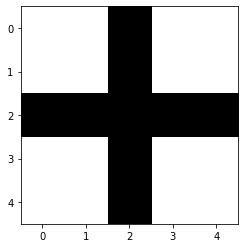

In [ ]:
plt.imshow(make_cross_image(), cmap="Greys");

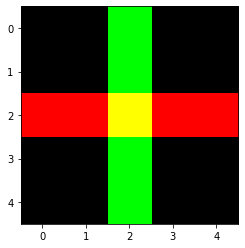

In [ ]:
plt.imshow(make_cross_image(False).permute(1,2,0));

In [ ]:
#export
def show_title(o, ax=None, ctx=None):
    "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
    ax = ifnone(ax,ctx)
    if ax is None: print(o)
    else: ax.set_title(o)
    return ax

In [ ]:
test_stdout(lambda: show_title("title"), "title")

In [ ]:
#export
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # Handle pytorch axis order
    if isinstance(im,Tensor):
        im = to_cpu(im)
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show b&w images...

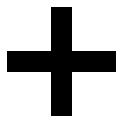

In [ ]:
im = make_cross_image()
ax = show_image(im, cmap="Greys", figsize=(2,2))

...and color images with standard `c*h*w` dim order...

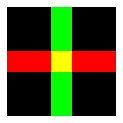

In [ ]:
im2 = make_cross_image(False)
ax = show_image(im2, figsize=(2,2))

...and color images with `h*w*c` dim order...

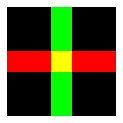

In [ ]:
im3 = im2.permute(1,2,0)
ax = show_image(im3, figsize=(2,2))

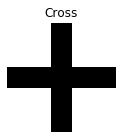

In [ ]:
ax = show_image(im, cmap="Greys", figsize=(2,2))
show_title("Cross", ax)

In [ ]:
#export
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

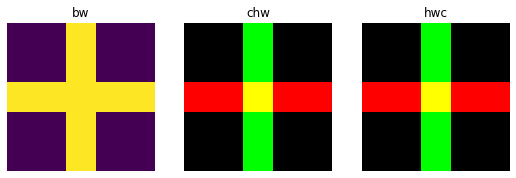

In [ ]:
show_image_batch(([im,im2,im3],['bw','chw','hwc']), items=3)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_script.ipynb.
Converted 02_transforms.ipynb.
Converted 03_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_rect_augment.ipynb.
Converted 10_data_block.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 30_text_core.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
